# 1. Introduction



In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold,cross_validate, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_auc_score, brier_score_loss, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibrationDisplay



#data = pd.read_csv('/Users/hungduong/Documents/MSBA UofU/MSBA 4th/MKTG 6620/churn_train.csv')

### Business Problem

### Leakage Policy

### Data overview and EDA

In [4]:
# Data highview
pd.set_option('display.max_columns', None)
data.head()

,ID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,yrhdgfy_4741,Male,0,No,No,35,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,49.20,1701.65,No
1,yrhdgfy_4154,Male,0,Yes,Yes,15,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,75.10,1151.55,No
2,yrhdgfy_5863,Male,0,Yes,Yes,13,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,Two year,No,Mailed check,40.55,590.35,No
3,yrhdgfy_4870,Female,0,Yes,No,26,Yes,No,DSL,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),73.50,1905.7,No
4,yrhdgfy_4813,Male,0,Yes,Yes,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,44.55,44.55,No


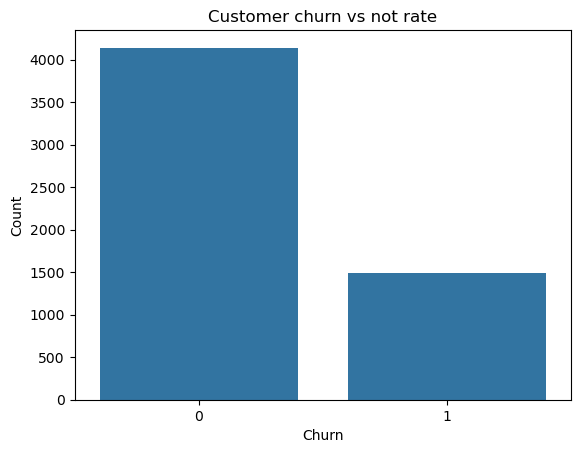

Churn rate is 26.54%


In [5]:
# Looks at Target variable
data['Churn'] = data['Churn'].map({'No':0, 'Yes':1})

sns.countplot(x='Churn', data=data)
plt.title('Customer churn vs not rate')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

#Target rate is imbalance
print(f"Churn rate is {data['Churn'].mean() * 100:.2f}%")


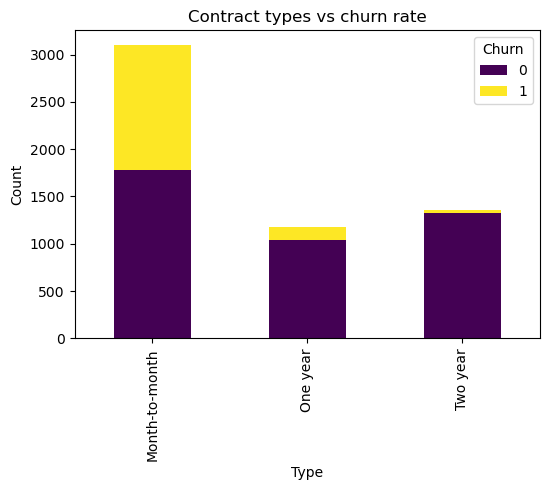

In [6]:
# How do contract type correlate with Churn?
pd.crosstab(data['Contract'], data['Churn']).plot(
    kind='bar',
    stacked=True,
    figsize=(6,4),
    colormap='viridis'
)

plt.title('Contract types vs churn rate')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

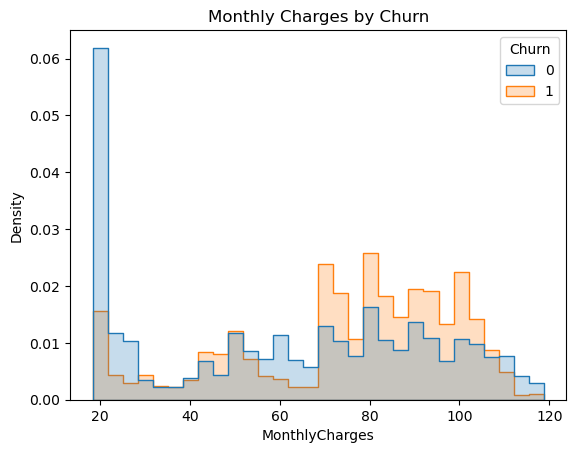

In [7]:
# How do monthly charges influence Churn?
sns.histplot(data=data, x='MonthlyCharges', hue='Churn',
             bins=30, stat='density', common_norm=False, element='step')
plt.title('Monthly Charges by Churn')
plt.xlabel('MonthlyCharges')
plt.ylabel('Density')
plt.show()

This plot is showing that people with low monthly charges tends not to churn, around $20-$40.


However, the group that churn the most seems to be high monthly charges ones noticeably around $70-$110.

# 2. Machine Learning

### Data preparation


In [9]:
# Prepare data for ML
data_ml = data.copy()

# get dummies variable
data_ml = pd.get_dummies(
    data_ml,
    columns=[
        'gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines',
        'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
        'StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod'
    ],
    drop_first=True  #
)

# Fix total charges dtype
data_ml['TotalCharges'] = pd.to_numeric(data_ml['TotalCharges'], errors='coerce').fillna(0)

# Check dtype
data_ml.dtypes

ID                                        object
tenure                                     int64
MonthlyCharges                           float64
TotalCharges                              object
Churn                                      int64
gender_Male                                 bool
SeniorCitizen_1                             bool
Partner_Yes                                 bool
Dependents_Yes                              bool
PhoneService_Yes                            bool
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
OnlineBackup_No internet service            bool
OnlineBackup_Yes                            bool
DeviceProtection_No internet service        bool
DeviceProtection_Yes                        bool
TechSupport_No inter

In [22]:
# Split data 
x = data_ml.drop(columns=['Churn', 'ID']) 
y = data_ml['Churn'] 
cv = StratifiedKFold(5, shuffle=True, random_state=111)

### Simple baseline Logistic Model

In [ ]:
# Logistic model with penalty Lasso Ridge
log_pipe = Pipeline(
    [("scaler", StandardScaler()), 
     ("logreg", LogisticRegression(penalty='elasticnet', C=1.0, 
                                   solver='saga', l1_ratio=0.5, 
                                   max_iter=1000, 
                                   class_weight='balanced' # handle class imbalance
                                   ))])

log_model_scores = cross_validate(
    log_pipe, x, y, 
    cv=cv, 
    scoring={'roc': 'roc_auc', 'acc': 'accuracy', 'f1': 'f1'}, 
    return_train_score=False )



In [31]:
# Result 
print(pd.DataFrame(log_model_scores)[['test_roc','test_acc','test_f1']].mean().round(3)) 

# Discrimination - AUC and Brier Score 
log_model_prob = cross_val_predict(log_pipe, x, y, cv=cv, method='predict_proba')[:, 1] 
auc_oof = roc_auc_score(y, log_model_prob) 
brier_oof = brier_score_loss(y, log_model_prob, pos_label=1) 

print(f"Discrimination AUC: {auc_oof:.3f}") 
print(f"Calibration Brier: {brier_oof:.4f}") 


# Feature importance 
log_pipe.fit(x, y) 
coef_table = pd.DataFrame({ "Feature": x.columns, "Coefficient": log_pipe.named_steps["logreg"].coef_.flatten() }) 
pd.set_option('display.max_rows', None) 
print(coef_table)

test_roc    0.845
test_acc    0.750
test_f1     0.629
dtype: float64
Discrimination AUC: 0.845
Calibration Brier: 0.1653
                                  Feature  Coefficient
0                                  tenure    -1.150569
1                          MonthlyCharges    -0.827876
2                            TotalCharges     0.483840
3                             gender_Male     0.015588
4                         SeniorCitizen_1     0.056214
5                             Partner_Yes     0.007983
6                          Dependents_Yes    -0.103979
7                        PhoneService_Yes     0.003065
8          MultipleLines_No phone service    -0.003065
9                       MultipleLines_Yes     0.184335
10            InternetService_Fiber optic     0.725037
11                     InternetService_No    -0.088434
12     OnlineSecurity_No internet service    -0.088434
13                     OnlineSecurity_Yes    -0.129359
14       OnlineBackup_No internet service    -0.088434

### Random Forest

In [68]:
rf_model = RandomForestClassifier(
    n_estimators=300,      
    max_depth=10,        
    random_state=42,       
    class_weight='balanced',  # handle class imbalance
    n_jobs=-1              
)

rf_model_scores = cross_validate(
    rf_model, x, y,
    cv=cv, 
    scoring={'roc': 'roc_auc', 'acc': 'accuracy', 'f1': 'f1'}, 
    return_train_score=False
)

In [69]:
# Result 
print(pd.DataFrame(rf_model_scores)[['test_roc','test_acc','test_f1']].mean().round(3)) 

# Discrimination - AUC and Brier Score 
rf_model_prob = cross_val_predict(rf_model, x, y, cv=cv, method='predict_proba')[:, 1] 
auc_oof = roc_auc_score(y, rf_model_prob) 
brier_oof = brier_score_loss(y, rf_model_prob, pos_label=1) 

print(f"Discrimination AUC: {auc_oof:.3f}") 
print(f"Calibration Brier: {brier_oof:.4f}") 

test_roc    0.844
test_acc    0.781
test_f1     0.634
dtype: float64
Discrimination AUC: 0.844
Calibration Brier: 0.1478


### Gradient Boosting Tree

In [62]:
gbt_model = GradientBoostingClassifier( 
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=3, 
    subsample=0.8, 
    random_state=42 ) 

gbt_score = cross_validate( 
    gbt_model, x, y, cv=cv, 
    scoring={'roc':'roc_auc', 'acc':'accuracy', 'f1':'f1'}, 
    return_train_score=True )

In [ ]:
print(pd.DataFrame(gbt_score)[['test_roc','test_acc','test_f1']].mean().round(3)) 


test_roc    0.842
test_acc    0.800
test_f1     0.584
dtype: float64
OOF ROC-AUC: 0.842
OOF Brier : 0.1371


OOF ROC-AUC: 0.842
OOF Brier : 0.1371


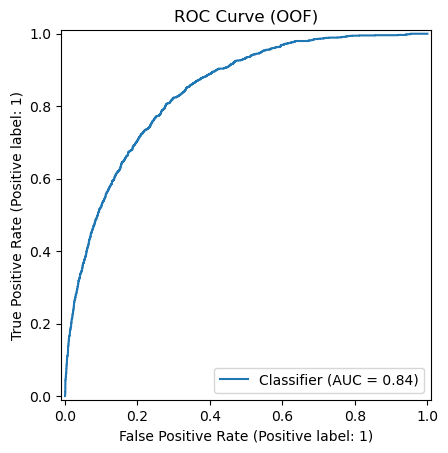

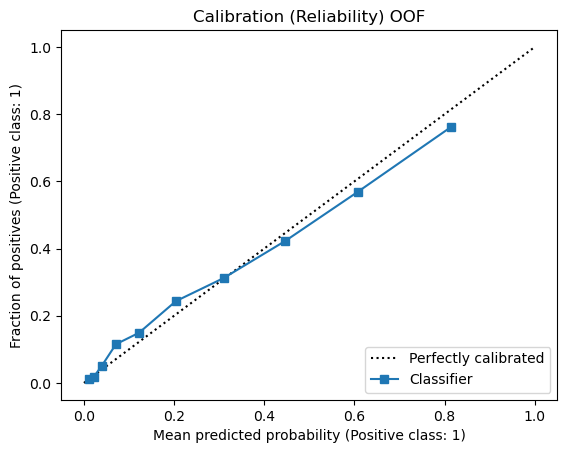

In [72]:
oof_proba = cross_val_predict(
    gbt_model, x, y, cv=cv, method='predict_proba'
)[:, 1]

# Metrics on OOF probs
auc_oof   = roc_auc_score(y, oof_proba)          # discrimination AUC
brier_oof = brier_score_loss(y, oof_proba)       # calibration (lower is better)

print(f"OOF ROC-AUC: {auc_oof:.3f}")
print(f"OOF Brier : {brier_oof:.4f}")

# Plots
RocCurveDisplay.from_predictions(y, oof_proba)
plt.title("ROC Curve (OOF)"); plt.show()

CalibrationDisplay.from_predictions(y, oof_proba, n_bins=10, strategy='quantile')
plt.title("Calibration (Reliability) OOF"); plt.show()

In [74]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import numpy as np
import pandas as pd

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y)

# Manual CV (because cross_validate doesn't pass fit_params in sklearn 1.7.2)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc, acc, f1 = [], [], []

for train_idx, val_idx in cv.split(x, y):
    X_train, X_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    w_train = sample_weights[train_idx]

    gbt_model.fit(X_train, y_train, sample_weight=w_train)

    p = gbt_model.predict_proba(X_val)[:, 1]
    y_pred = (p >= 0.5).astype(int)

    roc.append(roc_auc_score(y_val, p))
    acc.append(accuracy_score(y_val, y_pred))
    f1.append(f1_score(y_val, y_pred))

print(pd.Series({
    'ROC-AUC': np.mean(roc),
    'Accuracy': np.mean(acc),
    'F1': np.mean(f1)
}).round(3))


ROC-AUC     0.842
Accuracy    0.759
F1          0.626
dtype: float64


rf is better than gradientrf